In [1]:
import pandas as pd
import numpy as np
import math
import time
from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_style('whitegrid')

from fbprophet import Prophet
from pyramid.arima import auto_arima

from sklearn.metrics import mean_absolute_error


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true))

# Plotting functions

In [2]:
def plotting_features(exog, mode):
    """
    plotting features
    """
    
    if mode == 'prophet':
        Exog = exog.values
        
    elif mode == 'pyramid':
        Exog = exog

    else:
        print("check mode")
        return None
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)
    
    #left  = 0.125  # the left side of the subplots of the figure
    #right = 0.9    # the right side of the subplots of the figure
    #bottom = 0.1   # the bottom of the subplots of the figure
    #top = 0.9      # the top of the subplots of the figure
    #wspace = 0.2   # the amount of width reserved for blank space between subplots
    #hspace = 0.2   # the amount of height reserved for white space between subplots
    
    fig.subplots_adjust(top=2, bottom=1,  right=2, left=0, wspace=0.6)
    

    ax1.plot(Time,Exog[:,0])
    ax1.set_ylabel('exog_1', bbox=box)


    ax3.set_ylabel('exog_2',bbox=box)
    ax3.plot(Time,Exog[:,1])

    labelx = -0.3  # axes coords

    ax2.plot(Time,Exog[:,2])
    ax2.set_ylabel('exog_3', bbox=box)
    ax2.yaxis.set_label_coords(labelx, 0.5)


    ax4.plot(Time,Exog[:,3])
    ax4.set_ylabel('exog_4', bbox=box)
    ax4.yaxis.set_label_coords(labelx, 0.5)

    plt.show()
    
    pass

In [3]:
def plotting_time_series(y_without_lags, y_with_lags, mode):
    """
    Plot two time series
    """
    if mode == 'prophet':
        ts_without_lags = data_without_lags["y"].values
        ts_with_lags = data_with_lags["y"].values
        
    elif mode == 'pyramid':
        ts_without_lags = y_without_lags
        ts_with_lags = y_with_lags
        
    else:
        print("Check mode")
    
    box = dict(facecolor='yellow', pad=5, alpha=0.2)

    fig, ((ax1, ax2)) = plt.subplots(2, 1, figsize = (3, 7))
    fig.subplots_adjust(top = 2, bottom = 1,  right = 2, left = 0, hspace = 0.2)

    ax1.plot(Time, ts_without_lags)
    ax1.set_ylabel("value", bbox = box)
    ax1.set_title("y without lags", bbox = box)


    ax2.set_ylabel("value", bbox = box)
    ax2.plot(Time, ts_with_lags)
    ax2.set_title("y with lags", bbox = box)

    #fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

    plt.show()
    
    pass

In [4]:
def plot_results(time_series, Time, train_prediction, test_prediction, y_test, mode, description):
    
    """
    Plots the original time series and it prediction
    """
    if mode == 'prophet':
        ts = time_series["y"].values
        train_pr = train_prediction["yhat"].values
        test_pr = test_prediction["yhat"].values
    
    elif mode == 'pyramid':
        train_pr = train_prediction
        test_pr = test_prediction
        ts = time_series
        
    
    else:
        print("Check mode")
        return None
    
    plt.figure(figsize=(10,7))

    plt.plot(Time, ts, label = "true")
    
    plt.plot(Time[start_point+1: end_point], np.concatenate([train_pr, test_pr])[1:], 
         label = "predictions, \n MAPE = {0}, MAE = {1}".format(
             np.round(mean_absolute_percentage_error(test_pr, y_test), 3),
             np.round(mean_absolute_error(test_pr, y_test), 3)))


    plt.axvline(x=middle_point, label = "train-test-split", color = 'r')

    plt.xlabel("time", size = 20)
    plt.ylabel("value", size = 20)
    plt.title("{}".format(description), size = 20)


    plt.legend(fontsize = 15)

    plt.show()
    pass

# Extra functions

In [5]:
def generate_problem_linear(n_elements, mode = 'prophet', seed = 123, noise_scale = None):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([f_1(Time), f_2(Time), f_3(Time, period=12), f_4(Time, period=12)], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_1(Exog, noise_scale = noise_scale)
    
    y_with_lags = generate_ts_2(Exog, noise_scale = noise_scale)
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog)
        exog.columns = ["f1", "f2", "f3", "f4"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [6]:
def generate_problem_nonlinear(n_elements, mode = 'prophet', seed = 123, noise_scale = None):
    """
    Generates time-series, Exog, Time
    """
    # random seed
    np.random.seed(seed)
    
    Time = np.arange(0, n_elements)
    
    # generate exog features
    Exog = np.concatenate([f_1(Time), f_2(Time), f_3(Time, period=12), f_4(Time, period=12)], axis = 1)
    
    # generate time-series
    y_without_lags = generate_ts_nonlinear(Exog, noise_scale = noise_scale)
    
    y_with_lags = generate_ts_nonlinear_with_lags(Exog, noise_scale = noise_scale)
    
    if mode == 'prophet':
        
        # generate data frame
        data_without_lags = pd.DataFrame(y_without_lags)
        data_without_lags.columns = ["y"]
        data_without_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_without_lags), freq='M')

        data_with_lags = pd.DataFrame(y_with_lags)
        data_with_lags.columns = ["y"]
        data_with_lags["ds"] = pd.date_range(start='1/1/2018', periods=len(data_with_lags), freq='M')

        exog = pd.DataFrame(Exog)
        exog.columns = ["f1", "f2", "f3", "f4"]
        exog["ds"] = pd.date_range(start='1/1/2018', periods=len(exog), freq='M')
    
        return (data_without_lags, data_with_lags, exog, Time)
    
    elif mode == 'pyramid':
        return (y_without_lags, y_with_lags, Exog, Time)
    
    else:
        print("Check mode!")
        return None

In [7]:
def train_test_split(data, start_point, middle_point, end_point, mode, exog_flag = False):
    """
    Make train-test-split using input parameters
    """
    
    if mode == 'prophet':
        data_train = data.iloc[start_point: middle_point].copy()
        data_test = data.iloc[middle_point: end_point].copy()
        
        
        if exog_flag == False:
            
            y_test = data_test["y"].values
            del data_test["y"]
            
            return data_train, data_test, y_test
        
        else:
            
            return data_train, data_test
    
    elif mode == 'pyramid':
        
        data_train = data[start_point: middle_point]
        data_test = data[middle_point: end_point]
        
        if exog_flag == False:
            return data_train, data_test, data_test
        else:
            return data_train, data_test
        
    else:
        print("Check mode")
        return None, None, None

In [8]:
def Fit(mode, data_train, exog_train = None, params = None):
    
    """
    Fit the models
    """
    
    if mode == 'prophet':
        model = fit_prophet(data_train = data_train, exog_train = exog_train, params = params)
        
    elif mode == 'pyramid':
        model = fit_pyramid(data_train = data_train, exog_train = exog_train, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [9]:
def Predict(mode, model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Model prediction on train and test
    """
    
    if mode == 'prophet':
        model = predict_prophet(model = model, data_train = data_train, data_test = data_test, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    elif mode == 'pyramid':
        model = predict_pyramid(model = model, 
                                exog_train = exog_train, exog_test = exog_test, params = params)
        
    else:
        print("Check mode")
        model = None
        
    return model

In [10]:
def fit_prophet(data_train, exog_train = None, params = None):
    
    """
    Method fit for prophet
    """
    
    data_train_new = data_train.copy()
    
    model = Prophet()
    
    if exog_train is not None:
        
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        
        model.add_regressor("f1")
        model.add_regressor("f2")
        model.add_regressor("f3")
        model.add_regressor("f4")

    model.fit(data_train_new)
    
    return model

In [11]:
def predict_prophet(model, data_train, data_test, exog_train = None, exog_test = None, params = None):
    """
    Prediction for prophet
    """
    
    data_test_new = data_test.copy()
    data_train_new = data_train.copy()
    
    if exog_train is not None:
        data_train_new = pd.merge(data_train_new, exog_train, on = "ds")
        data_test_new = pd.merge(data_test_new, exog_test, on = "ds")
    
    forecast_train = model.predict(data_train_new)
    forecast_test = model.predict(data_test_new)
    
    return forecast_train, forecast_test

In [12]:
def fit_pyramid(data_train, exog_train = None, params = None):

    """
    pyramid_mode {"stepwise", "random_search"}

    """
    
    if params['pyramid_mode'] == "stepwise":
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5,
        m=params['period'], n_jobs = params['n_jobs'], scoring = params['scoring'], 
        out_of_sample_size = params['out_of_sample_size'], 
        start_P=0, start_Q = 0, max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, stepwise=True)
    
    elif params['pyramid_mode'] == 'random_search':
        model = auto_arima(data_train, exogenous=exog_train, start_p=0, start_q=0, max_p=5, max_q=5, 
        m=params['period'], scoring = params['scoring'], out_of_sample_size = params['out_of_sample_size'],
        start_P=0, start_Q = 0, n_jobs=params['n_jobs'], max_d=2, max_D=2,max_P = 5, max_Q = 5, trace=False,
        error_action='ignore', information_criterion = params['ic'], trend = params['trend'],
        suppress_warnings=True, 
        stepwise=False, random=True, random_state=params['random_state'], n_fits = params['n_fits'])
    
    return model

In [13]:
def predict_pyramid(model, exog_train = None, exog_test = None, params = None):
    
    predict_in_sample = model.predict_in_sample(exogenous = exog_train, dynamic = params['dynamic'])
    predict_out_of_sample = model.predict(n_periods = params['n_periods'], exogenous = exog_test)
    
    return predict_in_sample, predict_out_of_sample

# Data generation functions

In [14]:
def f_1(time):
    """
    time: np.array (len_ts,)
    """
    return time.reshape(-1,1)

def f_2(time):
    noise = np.random.randn(time.shape[0])
    f = lambda t: t * np.sin(t) + 200
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return (f_time+noise).reshape(-1,1)

def f_3(time, period):
    f = lambda t: 100 * np.sin(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def f_4(time, period):
    f = lambda t: 100 * np.cos(t // period) + 100 + 2*t
    vfunc = np.vectorize(f)
    f_time = vfunc(time)
    return f_time.reshape(-1,1)

def generate_ts_1(exog, noise_scale = None):
    """
    exog: np.array (len_ts, k_exog)
    """
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    y = exog @ a
    y = y.squeeze()
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y

def generate_ts_2(exog, noise_scale = None):
    
    y = np.zeros(exog.shape[0])
    a = (np.ones(exog.shape[1])/exog.shape[1]).reshape(-1,1)
    
    for i in range(exog.shape[0]):
        y[i] = exog[i] @ a
        if (y[i-1] != None):
            y[i] = y[i] + 0.3 * y[i-1]
        if (y[i-2] != None):
            y[i] = y[i] + 0.2 * y[i-2]
        if (y[i-3] != None):
            y[i] = y[i] + 0.1 * y[i-3]
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y


def generate_ts_nonlinear(exog, noise_scale = None):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    #y = 0.6 * exog[:, 2] / exog[:, 1] + exog[:, 2] / exog[:, 0]
    #y = np.sqrt(exog[:, 1] * exog[:, 3]) + exog[:, 2]  + np.sqrt(exog[:, 3] * exog[:, 2])
    
    y = (0.5 * np.power(exog[:, 2] * exog[:, 3], 1/3.) + 0.01 * exog[:, 1] + 0.1 * exog[:, 0] + 
                    np.power(exog[:, 2] * exog[:, 3], 1/3.))
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
    
    return y

def generate_ts_nonlinear_with_lags(exog, noise_scale = None):
    
    """
    exog: np.array (len_ts, number_exog), number_exog = 4
    """
    
    #y = 0.1 * exog[:, 1] / exog[:, 3] + exog[:, 2] / exog[:, 3] / 10 + exog[:, 0] / exog[:, 3] * 0.2
    
    #y = np.sqrt(exog[:, 1] * exog[:, 3]) + exog[:, 2]  + np.sqrt(exog[:, 3] * exog[:, 0])
    
    y = (0.5 * np.power(exog[:, 2] * exog[:, 3], 1/3.) + 0.01 * exog[:, 1] + 0.1 * exog[:, 0] + 
                    np.power(exog[:, 2] * exog[:, 3], 1/3.))

    for i in range(3, exog.shape[0]):
        
        y[i] =  y[i]  + 0.2 * y[i-1] - 0.3 * y[i-2] - 0.3 * y[i-3]
    
    
    if noise_scale is not None:
        noise = np.random.normal(scale = noise_scale * y, size = y.shape[0])
        y = y + noise
        
    return y


# Testing on the last dataset - linear case

# Prophet

In [15]:
# Global_mode
global_mode = 'prophet'
noise_scale = None

# Generate problem

In [16]:
n_samples = 300
data_without_lags, data_with_lags, exog, Time = generate_problem_nonlinear(n_samples, 
                        mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

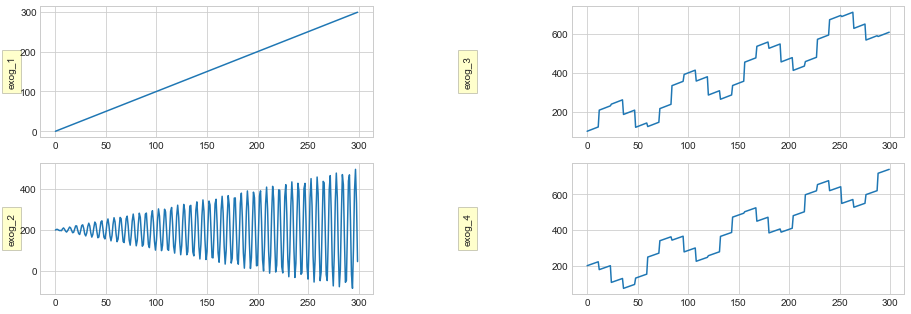

In [17]:
plotting_features(exog, global_mode)

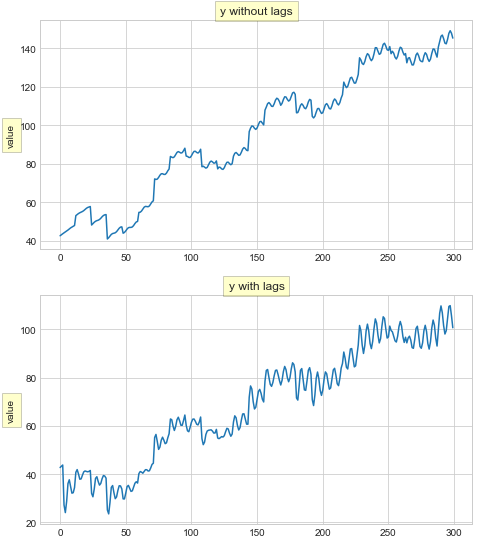

In [18]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [19]:
start_point = 0
middle_point = 100
end_point = 300

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet without lags without noise without exog

In [20]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [21]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

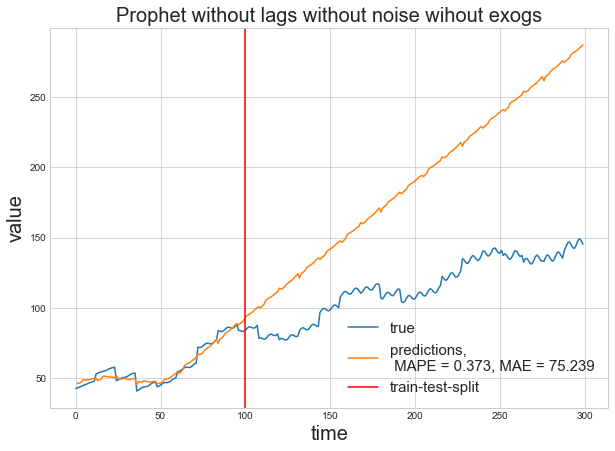

In [22]:
description = "Prophet without lags without noise wihout exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet without lags without noise with exogs 

In [23]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [24]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

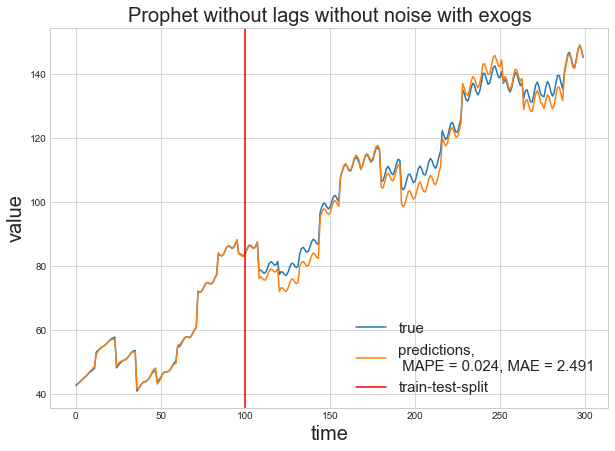

In [25]:
description = "Prophet without lags without noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet with lags without noise without exogs

In [26]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [27]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

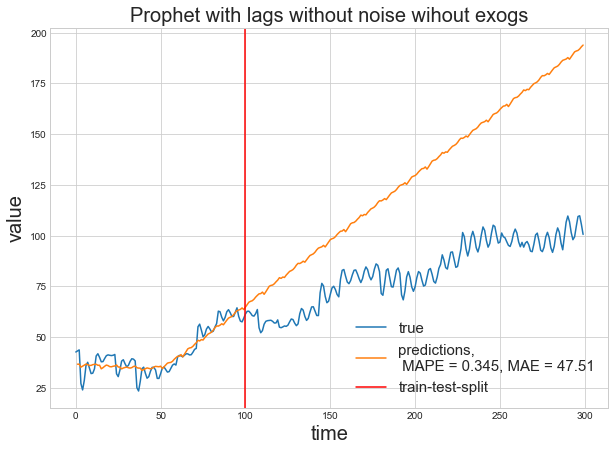

In [28]:
description = "Prophet with lags without noise wihout exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
                             y_test_with_lags, global_mode, description)

# Prophet with lags without noise with exogs

In [29]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [30]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

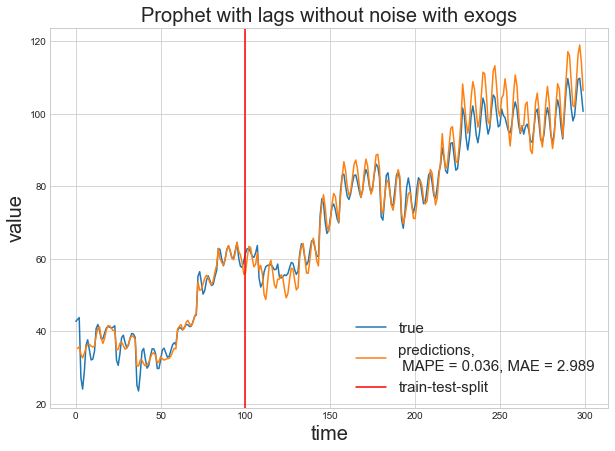

In [31]:
description = "Prophet with lags without noise with exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid Approach

In [32]:
# Global_mode
global_mode = 'pyramid'
noise_scale = None

# Generate problem

In [33]:
n_samples = 300
data_without_lags, data_with_lags, exog, Time = generate_problem_nonlinear(n_samples, 
                                mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

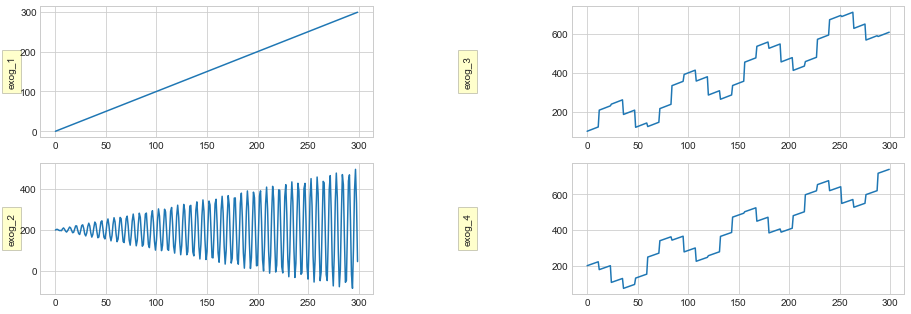

In [34]:
plotting_features(exog, global_mode)

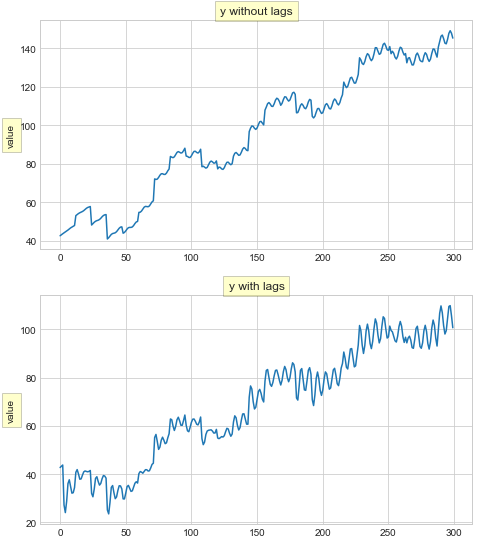

In [35]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [36]:
start_point = 0
middle_point = 100
end_point = 300

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Pyramid without lags without noise without exogs

In [37]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 12
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [38]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)
model.summary()

/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/sklearn/linear_model/base.py:509: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 1, 0)x(2, 0, 1, 12)   Log Likelihood                -134.394
Date:                            Thu, 19 Jul 2018   AIC                            278.787
Time:                                    19:12:17   BIC                            291.763
Sample:                                         0   HQIC                           284.037
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4042      0.081      5.009      0.000       0.246       0.562
ar.S.L12       1.0590      0.016     66.564      0.000       1.028       1.090
ar.S.L24      -0.9663      0.005   -206.557      0.000      -0.976      -0.957
ma.S.L12      -0.4268      0.114     -3.737      0.000      -0.651      -0.203
sigma2         0.4636      0.050      9.269      0.000       0.366       0.562
===================================================================================
Ljung-Box (Q):                       96.28   Jarque-Bera (JB):              1753.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.53   Skew:                            -3.58
Prob(H) (two-sided):                  0.07   Kurtosis:                        22.33
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [39]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

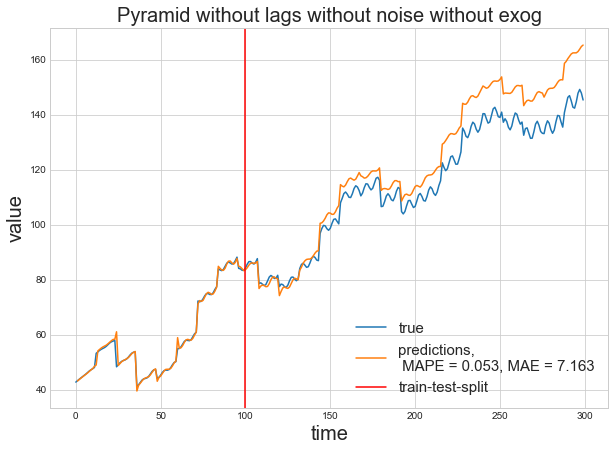

In [40]:
description = "Pyramid without lags without noise without exog"
plot_results(data_without_lags, Time, train_prediction, 
             test_prediction, y_test_without_lags, global_mode, description)

# Pyramid without lags without noise with exog

In [41]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 12
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [42]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

In [43]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

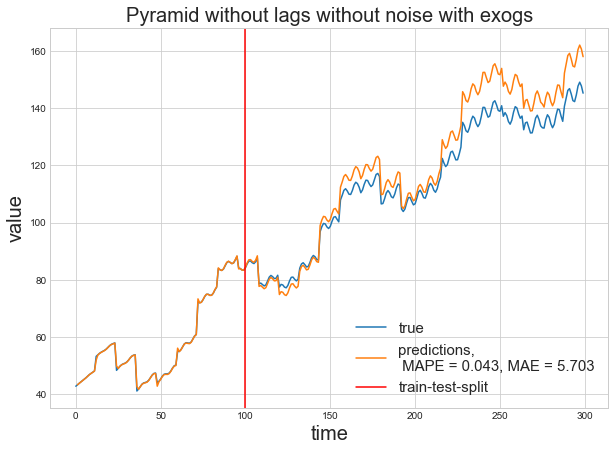

In [44]:
description = "Pyramid without lags without noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, 
             global_mode, description)

# Pyramid with lags without noise without exogs

In [45]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 12
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [46]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 1, 4)x(2, 0, 0, 12)   Log Likelihood                -199.653
Date:                            Thu, 19 Jul 2018   AIC                            415.307
Time:                                    19:12:39   BIC                            436.068
Sample:                                         0   HQIC                           423.707
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2290      0.113      2.027      0.043       0.008       0.450
ma.L1         -0.1394      0.065     -2.159      0.031      -0.266      -0.013
ma.L2         -0.0296      0.094     -0.316      0.752      -0.213       0.154
ma.L3         -0.6575      0.114     -5.761      0.000      -0.881      -0.434
ma.L4          0.1856      0.139      1.337      0.181      -0.087       0.458
ar.S.L12       1.0336      0.070     14.731      0.000       0.896       1.171
ar.S.L24      -0.8963      0.018    -48.609      0.000      -0.932      -0.860
sigma2         2.1189      0.239      8.865      0.000       1.650       2.587
===================================================================================
Ljung-Box (Q):                       51.06   Jarque-Bera (JB):               386.23
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               0.12   Skew:                            -2.15
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [47]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

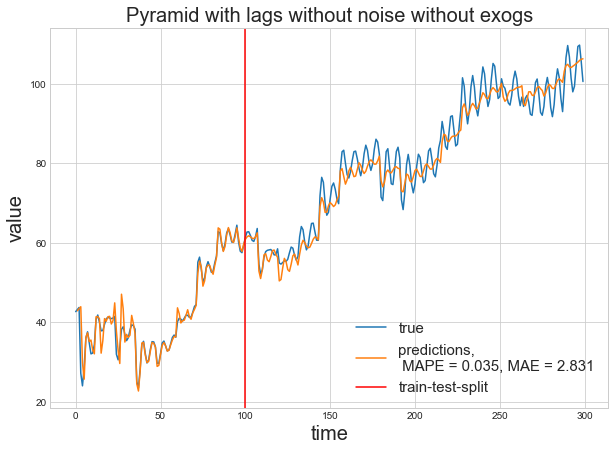

In [48]:
description = "Pyramid with lags without noise without exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid with lags without noise with exog

In [49]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 12
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [50]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

In [51]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(4, 0, 0)x(0, 0, 1, 12)   Log Likelihood                -185.026
Date:                            Thu, 19 Jul 2018   AIC                            392.053
Time:                                    19:13:03   BIC                            420.709
Sample:                                         0   HQIC                           403.650
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.2537      5.071      0.050      0.960      -9.685      10.193
x1             0.0388      0.022      1.732      0.083      -0.005       0.083
x2             0.0607      0.044      1.392      0.164      -0.025       0.146
x3             0.0587      0.007      8.329      0.000       0.045       0.073
x4             0.0716      0.006     11.914      0.000       0.060       0.083
ar.L1          0.6941      0.119      5.848      0.000       0.461       0.927
ar.L2         -0.0820      0.048     -1.692      0.091      -0.177       0.013
ar.L3         -0.7833      0.052    -14.956      0.000      -0.886      -0.681
ar.L4          0.5627      0.082      6.890      0.000       0.403       0.723
ma.S.L12       0.7029      0.163      4.301      0.000       0.383       1.023
sigma2         2.2437      0.390      5.746      0.000       1.478       3.009
===================================================================================
Ljung-Box (Q):                       43.98   Jarque-Bera (JB):                25.49
Prob(Q):                              0.31   Prob(JB):                         0.00
Heteroskedasticity (H):               0.22   Skew:                            -0.21
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.44
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [52]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

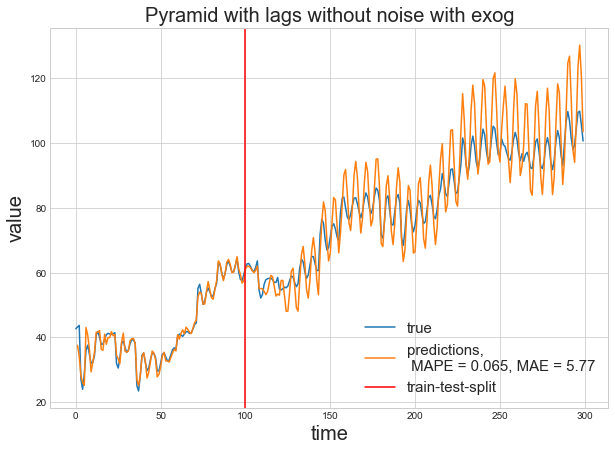

In [53]:
description = "Pyramid with lags without noise with exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

<b>noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise noise</b>

# Testing on the last dataset - linear case - with noise

# Prophet

In [54]:
# Global_mode
global_mode = 'prophet'
noise_scale = 0.05

# Generate problem

In [55]:
n_samples = 300
data_without_lags, data_with_lags, exog, Time = generate_problem_nonlinear(n_samples, 
                        mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

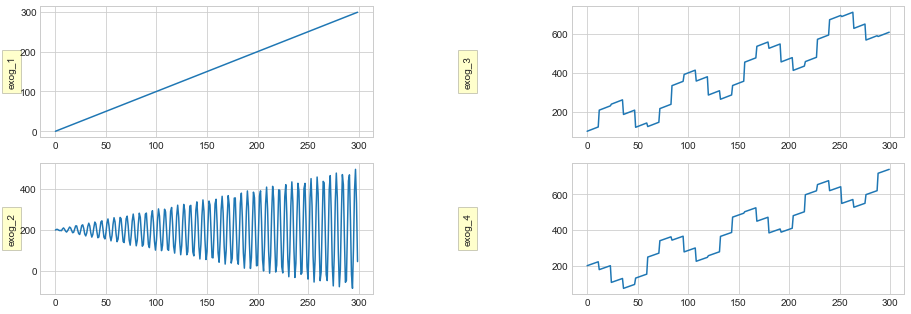

In [56]:
plotting_features(exog, global_mode)

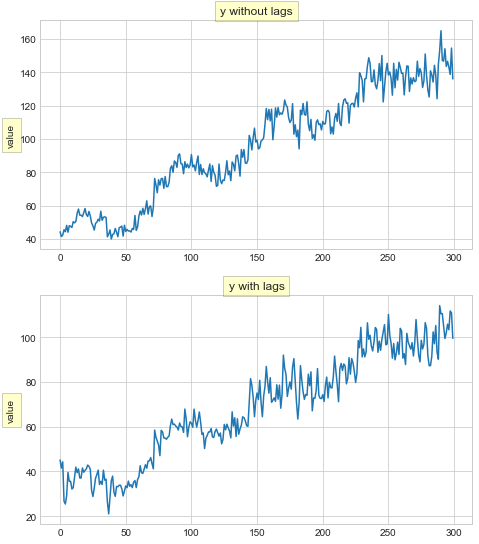

In [57]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [58]:
start_point = 0
middle_point = 100
end_point = 300

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Prophet without lags with noise without exog

In [59]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [60]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

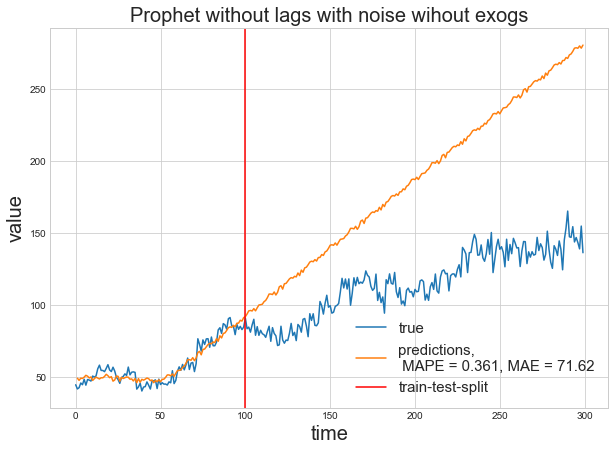

In [61]:
description = "Prophet without lags with noise wihout exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet without lags with noise with exogs 

In [62]:
params = None
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [63]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

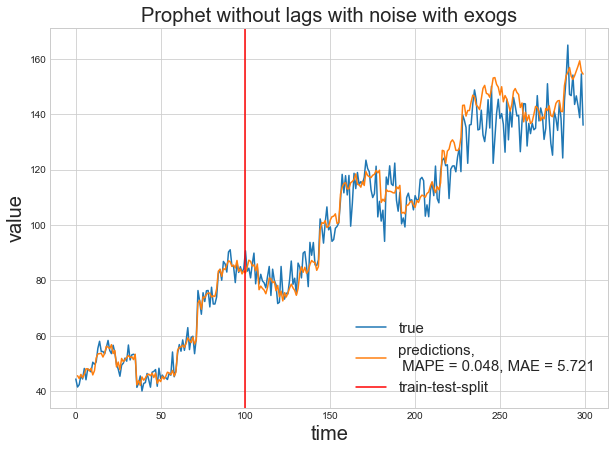

In [64]:
description = "Prophet without lags with noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, global_mode, description)

# Prophet with lags with noise without exogs

In [65]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [66]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

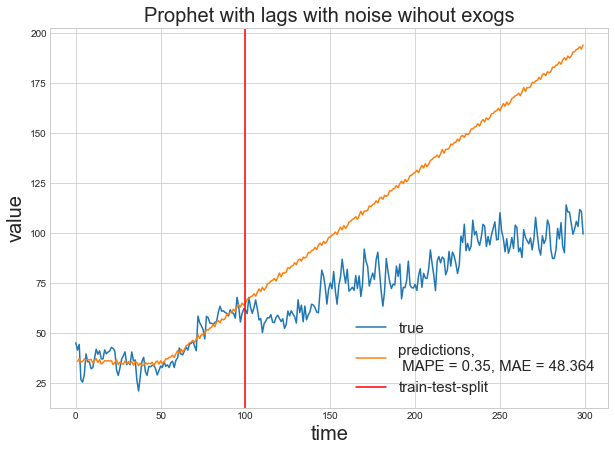

In [67]:
description = "Prophet with lags with noise wihout exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
                             y_test_with_lags, global_mode, description)

# Prophet with lags with noise with exogs

In [68]:
params = None
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
/Users/sergeymakarychev/anaconda/envs/deloitte/lib/python3.6/site-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [69]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test,
                                           params = params)

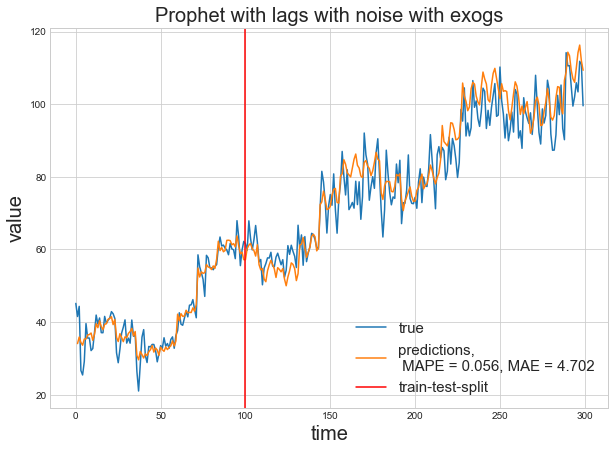

In [70]:
description = "Prophet with lags with noise with exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid Approach

In [71]:
# Global_mode
global_mode = 'pyramid'
noise_scale = 0.05

# Generate problem

In [72]:
n_samples = 300
data_without_lags, data_with_lags, exog, Time = generate_problem_nonlinear(n_samples, 
                                mode = global_mode, seed = 123, noise_scale = noise_scale)

# Plotting

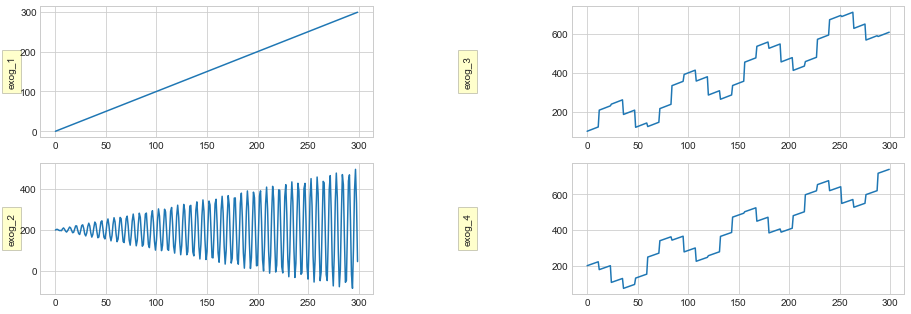

In [73]:
plotting_features(exog, global_mode)

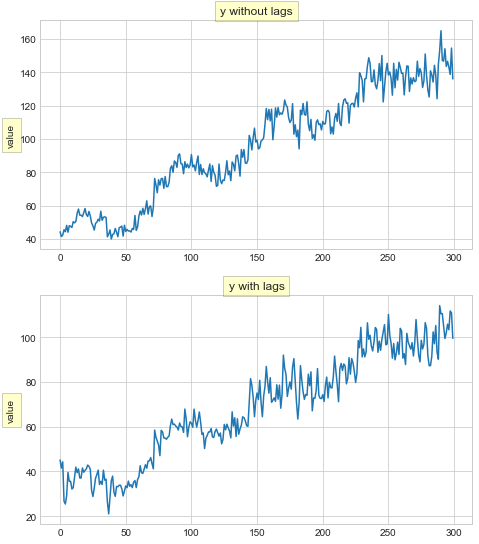

In [74]:
plotting_time_series(data_without_lags, data_with_lags, mode = global_mode)

# Train-test-split

In [75]:
start_point = 0
middle_point = 100
end_point = 300

data_train_without_lags, data_test_without_lags, y_test_without_lags = train_test_split(data_without_lags, start_point, 
                                           middle_point, end_point, global_mode, exog_flag = False)

data_train_with_lags, data_test_with_lags, y_test_with_lags = train_test_split(data_with_lags, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = False)


exog_train, exog_test = train_test_split(exog, start_point, 
                                           middle_point, end_point, mode = global_mode, exog_flag = True)

# Pyramid without lags with noise without exogs

In [76]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 12
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [77]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(0, 0, 1, 12)   Log Likelihood                -272.363
Date:                            Thu, 19 Jul 2018   AIC                            552.725
Time:                                    19:13:25   BIC                            563.106
Sample:                                         0   HQIC                           556.925
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.4179      0.274      1.523      0.128      -0.120       0.956
ma.L1         -0.4838      0.090     -5.392      0.000      -0.660      -0.308
ma.S.L12       0.3652      0.108      3.367      0.001       0.153       0.578
sigma2        14.0743      1.667      8.445      0.000      10.808      17.341
===================================================================================
Ljung-Box (Q):                       44.62   Jarque-Bera (JB):                18.75
Prob(Q):                              0.28   Prob(JB):                         0.00
Heteroskedasticity (H):               2.04   Skew:                             0.39
Prob(H) (two-sided):                  0.04   Kurtosis:                         4.98
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                                           params = params)

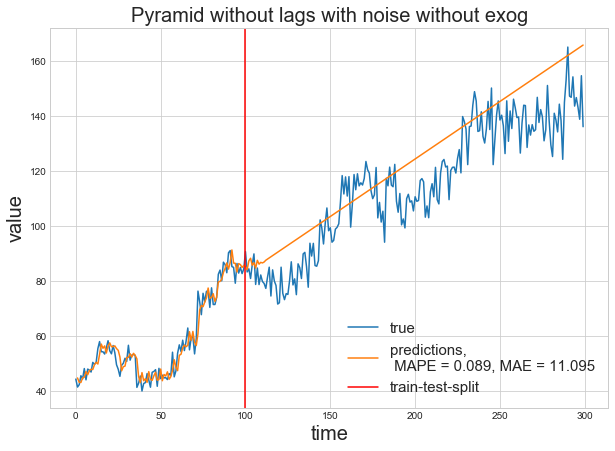

In [79]:
description = "Pyramid without lags with noise without exog"
plot_results(data_without_lags, Time, train_prediction, 
             test_prediction, y_test_without_lags, global_mode, description)

# Pyramid without lags with noise with exog

In [80]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 12
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [81]:
model = Fit(mode = global_mode, data_train = data_train_without_lags, exog_train = exog_train, params = params)

In [82]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_without_lags, data_test = data_test_without_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

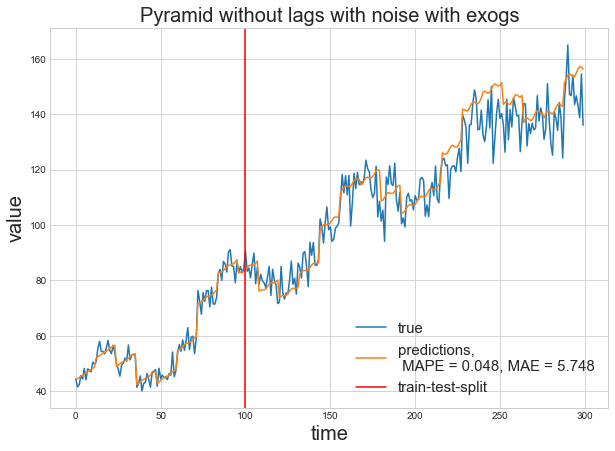

In [83]:
description = "Pyramid without lags with noise with exogs"
plot_results(data_without_lags, Time, train_prediction, test_prediction, y_test_without_lags, 
             global_mode, description)

# Pyramid with lags with noise without exogs

In [84]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 12
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [85]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, params = params)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  100
Model:             SARIMAX(0, 1, 1)x(4, 0, 1, 12)   Log Likelihood                -264.491
Date:                            Thu, 19 Jul 2018   AIC                            544.982
Time:                                    19:14:20   BIC                            565.743
Sample:                                         0   HQIC                           553.382
                                            - 100                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0947      0.105      0.903      0.367      -0.111       0.301
ma.L1         -0.7687      0.076    -10.152      0.000      -0.917      -0.620
ar.S.L12       1.1764      0.325      3.615      0.000       0.539       1.814
ar.S.L24      -0.5697      0.185     -3.086      0.002      -0.931      -0.208
ar.S.L36      -0.2511      0.201     -1.249      0.212      -0.645       0.143
ar.S.L48       0.4118      0.207      1.992      0.046       0.007       0.817
ma.S.L12      -0.9740      0.956     -1.018      0.308      -2.849       0.901
sigma2         8.9319      6.395      1.397      0.162      -3.601      21.465
===================================================================================
Ljung-Box (Q):                       38.72   Jarque-Bera (JB):                 6.22
Prob(Q):                              0.53   Prob(JB):                         0.04
Heteroskedasticity (H):               0.79   Skew:                            -0.54
Prob(H) (two-sided):                  0.50   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [86]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                                           params = params)

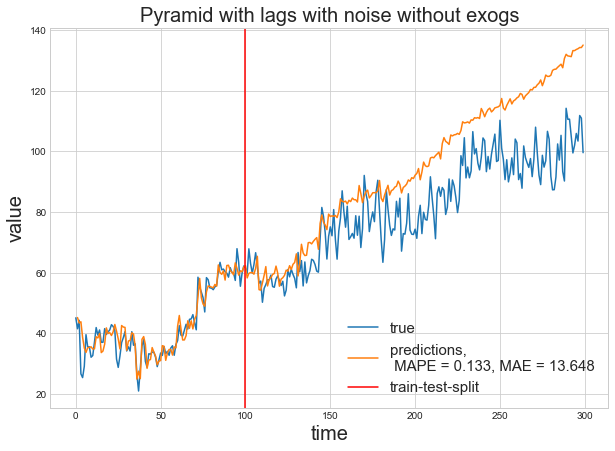

In [87]:
description = "Pyramid with lags with noise without exogs"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)

# Pyramid with lags with noise with exog

In [88]:
params = {}
params['pyramid_mode'] = 'stepwise'
params['ic'] = 'aic'
params['period'] = 12
params['random_state'] = 42
params['n_fits'] = 100
params['trend'] = 'c'
params['n_jobs'] = 1
params['scoring'] = 'mae'
params['out_of_sample_size'] = 0
params['dynamic'] = False
params['n_periods'] = end_point - middle_point

In [89]:
model = Fit(mode = global_mode, data_train = data_train_with_lags, exog_train = exog_train, params = params)

In [90]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:               SARIMAX(2, 0, 1)   Log Likelihood                -253.258
Date:                Thu, 19 Jul 2018   AIC                            524.515
Time:                        19:14:30   BIC                            547.962
Sample:                             0   HQIC                           534.005
                                - 100                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.3154      2.657      0.119      0.906      -4.892       5.523
x1             0.0484      0.004     12.857      0.000       0.041       0.056
x2             0.0649      0.025      2.631      0.009       0.017       0.113
x3             0.0486      0.001     37.221      0.000       0.046       0.051
x4             0.0750      0.001     61.553      0.000       0.073       0.077
ar.L1          1.0771      0.084     12.878      0.000       0.913       1.241
ar.L2         -0.6135      0.108     -5.663      0.000      -0.826      -0.401
ma.L1         -0.9898      0.231     -4.284      0.000      -1.443      -0.537
sigma2         9.7202      2.470      3.935      0.000       4.879      14.561
===================================================================================
Ljung-Box (Q):                       48.59   Jarque-Bera (JB):                 2.09
Prob(Q):                              0.17   Prob(JB):                         0.35
Heteroskedasticity (H):               0.84   Skew:                             0.20
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [91]:
train_prediction, test_prediction = Predict(mode = global_mode, model = model, 
                        data_train = data_train_with_lags, data_test = data_test_with_lags,
                        exog_train = exog_train, exog_test = exog_test, params = params)

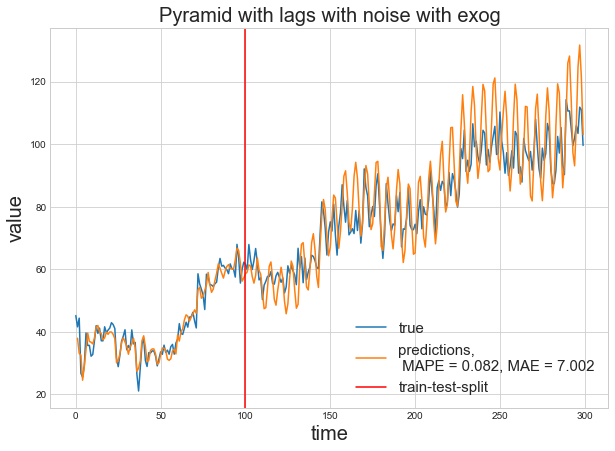

In [92]:
description = "Pyramid with lags with noise with exog"
plot_results(data_with_lags, Time, train_prediction, test_prediction, 
             y_test_with_lags, global_mode, description)